In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [40]:
def frac_delay_fir(ntaps, u):
    if u % 1 == 0:
        u += np.finfo(float).eps
    
    N = ntaps - 1
    n = np.linspace(-N/2, N/2, ntaps)
    win = signal.chebwin(ntaps, 70)
    return np.multiply(np.sinc(n - u), win.T)

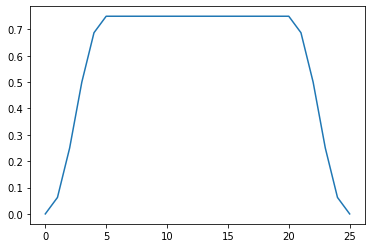

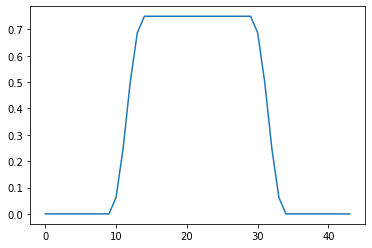

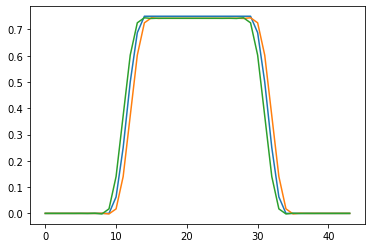

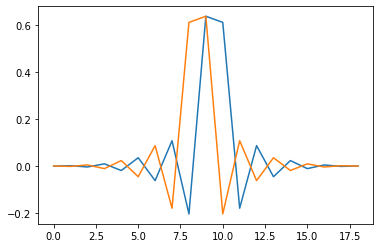

In [49]:
win = np.hanning(7)/4
x = np.convolve(win, np.ones(20))
b_zero = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
y1 = np.convolve(b_zero, x)

ntaps = 19
b_dly = frac_delay_fir(ntaps, 0.5)
b_adv = frac_delay_fir(ntaps, -0.5)
y2 = np.convolve(b_dly, x)
y3 = np.convolve(b_adv, x)

plt.figure()
plt.plot(x)

plt.figure()
plt.plot(y1)

plt.figure()
plt.plot(y1)
plt.plot(y2)
plt.plot(y3)

plt.figure()
plt.plot(b_dly)
plt.plot(b_adv)